In [14]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import pickle

In [15]:
# amplitude increment
def ampl_inc(J,b,c,zeta,p,sigma,attempt_num,dt):
    return (p*c + zeta*(torch.mm(J,c)+b))*dt + (sigma*torch.randn((c.size(0),attempt_num),dtype=torch.float32))*dt

# pump ramp
def pump(O,S,D,Jmax,N):
    i = torch.arange(N,dtype=torch.float32)
    arg = torch.tensor(S,dtype = torch.float32)*(i/N-0.5)
    return Jmax*O*(torch.tanh(arg) + D )

# coupling ramp
def coupling(init_value,final_value,dt,N): # redundant
    i = torch.arange(N).type(torch.float32)
    k = (final_value - init_value)/N/dt
    return init_value + k*i*dt

# amplitude initializer 
def init_ampl(dim, attempt_num):
    return torch.zeros((dim, attempt_num),dtype=torch.float32)

# evolution of amplitudes
# init_value -- init coupling
# final_value -- final coupling
# N -- number of time iterations
# attempt_num -- number of runs 
# J -- coupling matrix
# b -- biases
# O, S, D -- pump parameters
# sigma -- sqrt(var) for random number
# alpha -- momentum parameter
# c_th -- restriction on amplitudes growth
def evolve(N,attempt_num,dt,J,b,init_value,final_value,O,S,D,c_th,sigma,alpha):
    dim = J.size(0)
    Jmax = torch.max(torch.sum(torch.abs(J),1))
    
    # choosing an attempt for the amplitude evolution 
    random_attempt = np.random.randint(attempt_num)
    
    # initializing current amplitudes
    c_current = init_ampl(dim, attempt_num)
    
    # creating the array for evolving amplitudes from random attempt
    c_evol = torch.empty((dim, N),dtype=torch.float32)
    c_evol[:,0] = c_current[:,random_attempt]
    
    # define pump array
    p = pump(O,S,D,Jmax,N)
    
    
    # initializing moving average of amplitudes increment
    dc_momentum = torch.zeros((dim, attempt_num),dtype=torch.float32)
    for i in range(1,N):
        
        # calculating amplitude increment
        dc = ampl_inc(J,b,c_current,zeta,p[i],sigma,attempt_num,dt)
        
        # calculating moving average of amplitudes increment
        dc_momentum = alpha*dc_momentum + (1-alpha)*dc
        
        # calculating possible values of amplitudes on the next step
        c1 = c_current + dc_momentum
        
        # comparing c1 with c_th
        th_test = (torch.abs(c1)<c_th).type(torch.float32)
        
        # updating c_current
        c_current = c_current + th_test*dc_momentum
        
        # add amplitude values from random attempt to c_evol array 
        c_evol[:,i] = c_current[:,random_attempt]
        
    return c_current, c_evol

In [16]:
# G_in_shape = 800
# G=np.zeros((G_in_shape,G_in_shape))
# G_txt = np.loadtxt('G6.txt')
# for line in G_txt:
#     G[int(line[0]-1), int(line[1])-1] = -line[2]
#     G[int(line[1]-1), int(line[0])-1] = -line[2]    
    
# b = np.zeros((G_in_shape,1))

In [17]:
h_in = np.loadtxt('143h.txt', delimiter=' ')
G_in = np.loadtxt('143J.txt', delimiter=' ')
hypers_in = np.loadtxt('143hypers.txt', delimiter=' ')

slope_factor = float(hypers_in[0])
overall_factor = float(hypers_in[1])
displacement = float(hypers_in[2])
dt_const = float(hypers_in[3])
G_in_shape = int(hypers_in[4])

h = np.zeros((G_in_shape, 1))
G = np.zeros((G_in_shape,G_in_shape))

for i in range(G_in_shape):
    h[i] = h_in[i]

In [18]:
torch.cuda.empty_cache()
J = torch.tensor(-2*G,dtype=torch.float32) # removed -2 *
b = torch.tensor(-h,dtype=torch.float32) # removed - *
c_th = 1.
zeta = 1.
init_coupling = 0.3 # redundant
final_coupling = 1. # redundant
N = 1000
attempt_num = 100
dt = 0.01
sigma = 1
alpha = 0.9
Jmax = torch.max(torch.sum(torch.abs(J),1))

S = 1.5
D = 0.5
O = 0.1

In [19]:
t0 = time.time()
c_current, c_evol = evolve(N,attempt_num,dt,J,b,init_coupling,final_coupling,O,S,D,c_th,sigma,alpha)
spins_current = torch.sign(c_current)
spins_evol = torch.sign(c_evol)
energy = -0.5*torch.einsum('ij,ik,jk->k',(J,spins_current,spins_current)) - torch.einsum('ij,ik->k',(b,spins_current))
# cut = 0.25*(torch.einsum('ij,ik,jk->k',(J,spins_current,spins_current))-torch.sum(J))
t1=time.time()
print(t1-t0)

0.0927741527557373


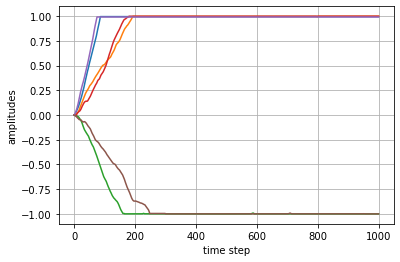

In [20]:
for i in range(J.size(0)):
    plt.plot(c_evol[i,:].cpu().numpy())
plt.grid()
plt.xlabel('time step')
plt.ylabel('amplitudes')
plt.show()

In [21]:
spins_current[:, torch.argmin(energy)]

tensor([ 1.,  1., -1.,  1.,  1., -1.])

tensor(-5.)
tensor(-5.)


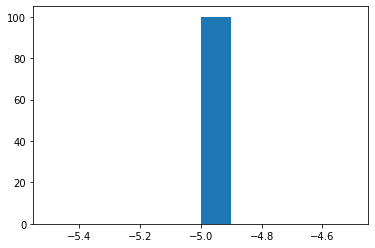

In [22]:
plt.hist(energy.cpu().numpy())
print(torch.min(energy))
print(torch.mean(energy))

In [23]:
s_exact = [1, 1, -1, 1, 1, -1]
s_exact = torch.tensor(s_exact,dtype=torch.float32)
E_exact = -0.5*torch.einsum('ij,i,j->',(J,s_exact,s_exact)) - torch.einsum('ij,i->',(b,s_exact))

In [24]:
E_exact

tensor(-5.)

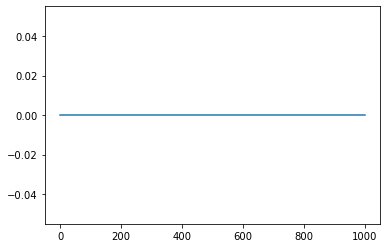

In [25]:
plt.plot(pump(O,S,D,Jmax,N).cpu().numpy())

In [37]:
spins_current[:,torch.argmin(energy)]

tensor([ 1.,  1., -1.,  1.,  1., -1.])